In [1]:
import json
import numpy as np
import os
from colmap_loader import read_extrinsics_binary, read_intrinsics_binary, qvec2rotmat
import pyembree.rtcore_scene as rtcs
from pyembree.mesh_construction import TriangleMesh
import trimesh
def load_match_matrices_from_json(json_file):
    """
    从 JSON 文件中加载匹配矩阵，保留三维列表格式。

    Args:
        json_file (str): JSON 文件的路径。

    Returns:
        list: 包含所有帧匹配矩阵的列表，每个元素是一个三维列表。
    """
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    match_matrices_list = data.get("match_matrices", [])
    
    if not match_matrices_list:
        print("Warning: No 'match_matrices' found in the JSON file or it is empty.")
        return []
    
    # 直接返回原始列表，不做numpy转换
    return match_matrices_list

def load_keypoints_from_json(json_file):
    """
    从 JSON 文件中加载关键点位置信息。

    Args:
        json_file (str): JSON 文件的路径。

    Returns:
        list: 包含所有帧关键点位置信息的列表，每个元素是一个numpy数组。
    """
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    keypoints_list = data.get("keypoints", [])
    if not keypoints_list:
        print("Warning: No 'keypoints' found in the JSON file or it is empty.")
        return []
        
    # 将列表中的子列表转成numpy 数组    
    keypoints = [np.array(kps) for kps in keypoints_list]
    
    return keypoints

def load_3Dkeypoints_from_json(json_file):
    """
    从 JSON 文件中加载关键点位置信息。

    Args:
        json_file (str): JSON 文件的路径。

    Returns:
        list: 包含所有帧关键点位置信息的列表，每个元素是一个numpy数组。
    """
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    keypoints_list = data.get("point_clouds", [])
    if not keypoints_list:
        print("Warning: No 'keypoints' found in the JSON file or it is empty.")
        return []
        
    # 将列表中的子列表转成numpy 数组    
    keypoints = [np.array(kps) for kps in keypoints_list]
    
    return keypoints

def find_longest_match_trajectory(all_match_matrices):
    """
    在匹配矩阵中查找所有关键点中最长的连续匹配轨迹。

    Args:
        all_match_matrices (list): 包含所有帧匹配矩阵的列表，每个元素是一个三维列表。

    Returns:
         tuple: (longest_match_start_frame, longest_match_start_keypoint), 最长匹配轨迹的起始帧和关键点索引
    """
    longest_match_length = 0          # 初始化最长匹配长度为0
    longest_match_start_frame = -1    # 初始化最长匹配轨迹的起始帧为-1
    longest_match_start_keypoint = -1 # 初始化最长匹配轨迹的起始关键点为-1
    num_frames = len(all_match_matrices)+1 # 获取总帧数
    
    # 遍历所有可能的起始帧
    for start_frame_index in range(num_frames-1):
        # 获得当前帧的关键点数量
    
        num_keypoints = np.array(all_match_matrices[start_frame_index]).shape[0]
    
            
        # 遍历当前帧的所有关键点
        for start_keypoint_index in range(num_keypoints):
            current_keypoint = start_keypoint_index   # 初始化当前关键点为起始关键点
            match_length = 0                         # 初始化当前匹配轨迹的长度为0
        
            # 从当前起始帧开始，遍历后续帧，查找匹配轨迹
            for next_frame in range(start_frame_index, num_frames-1):
                # 将下一帧的匹配矩阵转换为 numpy 数组
                match_matrix = np.array(all_match_matrices[next_frame])
                # 如果当前关键点索引大于或等于下一帧的匹配矩阵的行数，则退出内层循环
                if current_keypoint >= match_matrix.shape[0]:
                    break
                # 获取下一帧匹配的关键点索引, 使用np.where 获取匹配矩阵中当前关键点为1的索引，返回的是一个元组，索引值在第一个元素中
                next_keypoint_indices = np.where(match_matrix[current_keypoint] == 1)[0]
                
                # 如果没有找到匹配的关键点，则退出内层循环
                if next_keypoint_indices.size == 0:
                    break
            
                match_length += 1 # 如果找到匹配的关键点，则匹配轨迹长度加1
                current_keypoint = next_keypoint_indices[0] # 更新当前关键点为匹配到的下一个关键点的索引
                # 如果当前匹配轨迹长度大于最长匹配轨迹长度，则更新最长匹配轨迹的长度，起始帧和起始关键点
                if match_length > longest_match_length:
                    longest_match_length = match_length
                    longest_match_start_frame = start_frame_index
                    longest_match_start_keypoint = start_keypoint_index

    return longest_match_start_frame, longest_match_start_keypoint, longest_match_length # 返回具有最长匹配轨迹的起始帧和关键点索引

def complete_keypoint_trajectory(match_matrices_list, keypoints, which_frame, keypoint_idx):
    """
    补全关键点轨迹。

    Args:
        match_matrices_list (list): 匹配矩阵列表。
        keypoints (list): 所有帧的关键点位置列表, 列表的列表。
        which_frame (int): 需要补全的关键点首次出现的帧数。
        keypoint_idx (int): 需要补全的关键点在其首次出现帧中的下标。

    Returns:
        np.ndarray: 补全后的关键点轨迹，形状为 (总帧数, 2)。
        
    """
    total_frames = len(keypoints)
    completed_trajectory = np.full((total_frames, 2), np.nan)  # Initialize with NaN
    color_flag = np.zeros(total_frames)
    completed_trajectory[which_frame] = keypoints[which_frame][keypoint_idx]  # Set the first keypoint

    # 找到该关键点最后一次匹配成功的帧
    last_matched_frame = which_frame
    temp_keypoint_idx = keypoint_idx
    for i in range(which_frame, total_frames -1):
        matrix = match_matrices_list[i]
        
        
        is_matched = False
        if temp_keypoint_idx < len(matrix):
          for j in range(len(matrix[temp_keypoint_idx])):
            if matrix[temp_keypoint_idx][j] == 1:
                is_matched = True
                
                last_matched_frame = i + 1
                temp_keypoint_idx = j
                

                current_keypoint_pos = keypoints[last_matched_frame][j]
                completed_trajectory[last_matched_frame] = current_keypoint_pos

                break
        if not is_matched:
          break
            

    print("last_frame", last_matched_frame)



    # 第一类补全（向前补全）
    current_frame = which_frame
    current_keypoint_pos = keypoints[current_frame][keypoint_idx]

    for prev_frame in range(which_frame - 1, -1, -1):
        match_matrix = match_matrices_list[prev_frame]

        # 检查当前关键点是否在匹配矩阵中匹配
        is_matched = False

        if keypoint_idx < len(match_matrix[0]) and keypoint_idx != -1: # 确保 keypoint_idx 不超出列的范围
          for j in range(len(match_matrix)):
            if match_matrix[j][keypoint_idx] == 1:
                is_matched = True
                # 找到匹配的关键点在前一帧的索引

                keypoint_idx = j
                current_keypoint_pos = keypoints[prev_frame][keypoint_idx]
                completed_trajectory[prev_frame] = current_keypoint_pos
                break

        if is_matched:
            continue # 如果当前关键点已匹配，则跳过平均位移计算

        matched_keypoints_prev = []
        matched_keypoints_curr = []

        for i in range(len(match_matrix)):
            for j in range(len(match_matrix[i])):
                if match_matrix[i][j] == 1:
                    matched_keypoints_prev.append(keypoints[prev_frame][i])
                    matched_keypoints_curr.append(keypoints[prev_frame+1][j])

        # 先使用平均位移计算
        if matched_keypoints_prev:
            # 分别计算 x 和 y 方向的位移
            # displacements_x = np.array(matched_keypoints_curr)[:, 0] - np.array(matched_keypoints_prev)[:, 0]
            # displacements_y = np.array(matched_keypoints_curr)[:, 1] - np.array(matched_keypoints_prev)[:, 1]

            # # 分别计算 x 和 y 方向的平均位移
            # avg_displacement_x = np.mean(displacements_x)
            # avg_displacement_y = np.mean(displacements_y)

            #--------------------------------------------------
            # 计算当前关键点与所有其他关键点的距离
            distances = np.linalg.norm(np.array(matched_keypoints_curr) - current_keypoint_pos, axis=1)

            # 获取距离最近的五个关键点的索引
            k = min(5, len(matched_keypoints_prev))  # 确保不超过总匹配关键点的数量
            nearest_indices = np.argsort(distances)[:k]

            # 使用最近的五个关键点来计算位移
            nearest_keypoints_prev = np.array(matched_keypoints_prev)[nearest_indices]
            nearest_keypoints_curr = np.array(matched_keypoints_curr)[nearest_indices]

            # 分别计算 x 和 y 方向的位移
            displacements_x = nearest_keypoints_curr[:, 0] - nearest_keypoints_prev[:, 0]
            displacements_y = nearest_keypoints_curr[:, 1] - nearest_keypoints_prev[:, 1]

            # 分别计算 x 和 y 方向的平均位移
            avg_displacement_x = np.mean(displacements_x)
            avg_displacement_y = np.mean(displacements_y)
            #--------------------------------------------------

            # 使用各自的平均位移来估计前一帧的 x 和 y 坐标
            estimated_pos_x = current_keypoint_pos[0] - avg_displacement_x
            estimated_pos_y = current_keypoint_pos[1] - avg_displacement_y

            current_keypoint_pos = np.array([estimated_pos_x, estimated_pos_y])
            
            completed_trajectory[prev_frame] = current_keypoint_pos
            color_flag[prev_frame] = 1
            keypoint_idx = -1

        else:
            # 没有匹配的点了，报错
            print(f"向前补全失败, {prev_frame}")
            assert 0
            completed_trajectory[prev_frame] = current_keypoint_pos

        # 尝试查找在1像素范围内是否有关键点
        distances = np.linalg.norm(keypoints[prev_frame] - current_keypoint_pos, axis=1)
        nearest_keypoint_idx = np.argmin(distances)

        if distances[nearest_keypoint_idx] <= 1:
            # 直接将该点视为匹配的关键点，并更新 keypoint_idx

            current_keypoint_pos = keypoints[prev_frame][nearest_keypoint_idx]
            completed_trajectory[prev_frame] = current_keypoint_pos
            keypoint_idx = nearest_keypoint_idx #更新下标


    # 第二类补全（向后补全）
    current_frame = last_matched_frame
    current_keypoint_pos = keypoints[current_frame][temp_keypoint_idx]
    keypoint_idx = temp_keypoint_idx

    for next_frame in range(last_matched_frame + 1, total_frames):
        match_matrix = match_matrices_list[next_frame-1]

        # 检查当前关键点是否在匹配矩阵中匹配
        is_matched = False

        #找到上一帧中和该点匹配的点
        if keypoint_idx < len(match_matrix) and keypoint_idx != -1:
            for i in range(len(match_matrix[keypoint_idx])):
                if match_matrix[keypoint_idx][i] == 1:

                    is_matched = True
                    current_keypoint_pos = keypoints[next_frame][i]
                    completed_trajectory[next_frame] = current_keypoint_pos

                    keypoint_idx = i

                    break
        if is_matched:
            continue

        matched_keypoints_prev = []
        matched_keypoints_curr = []

        for i in range(len(match_matrix)):
            for j in range(len(match_matrix[i])):
                if match_matrix[i][j] == 1:
                    matched_keypoints_prev.append(keypoints[next_frame-1][i])
                    matched_keypoints_curr.append(keypoints[next_frame][j])

        #先进行平均位移计算
        if matched_keypoints_prev:
            # # 分别计算 x 和 y 方向的位移
            # displacements_x = np.array(matched_keypoints_curr)[:, 0] - np.array(matched_keypoints_prev)[:, 0]
            # displacements_y = np.array(matched_keypoints_curr)[:, 1] - np.array(matched_keypoints_prev)[:, 1]

            # # 分别计算 x 和 y 方向的平均位移
            # avg_displacement_x = np.mean(displacements_x)
            # avg_displacement_y = np.mean(displacements_y)
            #--------------------------------------------------
            # 计算当前关键点与所有其他关键点的距离
            distances = np.linalg.norm(np.array(matched_keypoints_curr) - current_keypoint_pos, axis=1)

            # 获取距离最近的五个关键点的索引
            k = min(5, len(matched_keypoints_prev))  # 确保不超过总匹配关键点的数量
            nearest_indices = np.argsort(distances)[:k]

            # 使用最近的五个关键点来计算位移
            nearest_keypoints_prev = np.array(matched_keypoints_prev)[nearest_indices]
            nearest_keypoints_curr = np.array(matched_keypoints_curr)[nearest_indices]

            # 分别计算 x 和 y 方向的位移
            displacements_x = nearest_keypoints_curr[:, 0] - nearest_keypoints_prev[:, 0]
            displacements_y = nearest_keypoints_curr[:, 1] - nearest_keypoints_prev[:, 1]

            # 分别计算 x 和 y 方向的平均位移
            avg_displacement_x = np.mean(displacements_x)
            avg_displacement_y = np.mean(displacements_y)
            #--------------------------------------------------

            # 使用各自的平均位移来估计后一帧的 x 和 y 坐标
            estimated_pos_x = current_keypoint_pos[0] + avg_displacement_x
            estimated_pos_y = current_keypoint_pos[1] + avg_displacement_y

            current_keypoint_pos = np.array([estimated_pos_x, estimated_pos_y])
            completed_trajectory[next_frame] = current_keypoint_pos
            color_flag[next_frame] = 1
            keypoint_idx = -1

        else:
            print(f"向后补全失败, {next_frame}")
            assert 0
            completed_trajectory[next_frame] = current_keypoint_pos

        # 尝试查找在当前帧1像素范围内是否有关键点
        distances = np.linalg.norm(keypoints[next_frame] - current_keypoint_pos, axis=1)
        nearest_keypoint_idx = np.argmin(distances)

        if distances[nearest_keypoint_idx] <= 1:
            # 直接将该点视为匹配的关键点，并更新 keypoint_idx
            current_keypoint_pos = keypoints[next_frame][nearest_keypoint_idx]
            completed_trajectory[next_frame] = current_keypoint_pos
            keypoint_idx = nearest_keypoint_idx




    return completed_trajectory, color_flag

def get_3d_coordinates_flame(mesh_path, params, R, T, keypoints_2d):
    """
    计算相机视角下二维关键点对应的Mesh上的三维坐标。

    Args:
        mesh_path (str): .ply文件的路径。
        params (list): 相机内参 [fx, cx, cy, k]。
        R (np.ndarray): 相机外参旋转矩阵，形状为 (3, 3)。
        T (np.ndarray): 相机外参平移向量，形状为 (3, 1)。
        keypoints_2d (np.ndarray): 二维关键点坐标，形状为 (N, 2)。

    Returns:
        tuple: (valid_keypoints_2d, valid_intersections), 其中：
            - valid_keypoints_2d (np.ndarray):  形状为 (M, 2) 的有效二维关键点数组 (M <= N)。
            - valid_intersections (np.ndarray): 形状为 (M, 3) 的有效三维交点数组。
    """
    keypoints_2d = np.array(keypoints_2d)

    # 1. 加载Mesh
    mesh = trimesh.load_mesh(mesh_path)
    triangles = mesh.vertices[mesh.faces]

    # 2. 构建Embree场景
    scene = rtcs.EmbreeScene()
    mesh_embree = TriangleMesh(scene, triangles.astype(np.float32))

    # 3. 相机参数 (简化：假设 fx=fy)
    fx = params[0]
    fy = params[1]
    cx = params[2]
    cy = params[3]
   

    # 4. 去畸变
    # undistorted_keypoints = undistort_point(keypoints_2d, [f, cx, cy, k])

    # 5. 构建射线 (考虑外参)
    # 相机中心在世界坐标系下的坐标:
    origin = -R.T @ T  # (3, 1)
    origin = origin.reshape(3)  # 转换为 (3,)，方便后续计算

    # 射线方向 (在相机坐标系下)
    x = (keypoints_2d[:, 0] - cx) / fx
    y = (keypoints_2d[:, 1] - cy) / fy
    direction_camera = np.stack([x, y, np.ones_like(x)], axis=-1)  # (N, 3)

    # 将射线方向从相机坐标系转换到世界坐标系
    direction_world = (R.T @ direction_camera.T).T  # (N, 3)

    # 单位化世界坐标系下的方向向量
    direction_world = direction_world / np.linalg.norm(direction_world, axis=1, keepdims=True)

    # 6. 射线求交
    origins = np.tile(origin, (keypoints_2d.shape[0], 1))  # (N, 3)
    res = scene.run(origins.astype(np.float32), direction_world.astype(np.float32), output=1)

    # 7. 获取交点和有效关键点
    valid_intersections = []
    valid_keypoints_2d = []

    valid_intersections_mask = res['geomID'] != -1 # (N,) boolean array
    valid_indices = np.where(valid_intersections_mask)[0]  # 获取有效交点的索引
    
    if valid_indices.size > 0:   # 确保存在有效交点才执行计算
        primIDs = res['primID'][valid_indices]
        u = res['u'][valid_indices]
        v = res['v'][valid_indices]
        w = 1 - u - v

        # 使用有效索引进行批量计算
        valid_intersections = (w[:, None] * triangles[primIDs, 0] +
                                         u[:, None] * triangles[primIDs, 1] +
                                         v[:, None] * triangles[primIDs, 2])

        valid_keypoints_2d = keypoints_2d[valid_indices]

    return valid_keypoints_2d, valid_intersections

def get_k_w2c_flame(datadir, cam_id):
    cam1 = '222200042'
    cam2 = '222200044'
    cam3 = '222200046'
    cam4 = '222200040'
    cam5 = '222200036'  #
    cam6 = '222200048'
    cam7 = '220700191'
    cam8 = '222200041'
    cam9 = '222200037'
    cam10 = '222200038'  #
    cam11 = '222200047'
    cam12 = '222200043'
    cam13 = '222200049'
    cam14 = '222200039'
    cam15 = '222200045' #
    cam16 = '221501007'
    cam_identifiers = [cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8, cam9, cam10, cam11, cam12, cam13, cam14, cam15, cam16]
    with open(datadir, 'r') as file:
        params = json.load(file)
    
    extrinsic = np.array(params['world_2_cam'][cam_identifiers[int(cam_id)-1]])
    # 提取旋转矩阵 R
    R = extrinsic[:3, :3]
    # 提取平移向量 T
    T = extrinsic[:3, 3]
    # 提取相机内参
    intrinsic = np.array(params['intrinsics'])
    param = [intrinsic[0,0], intrinsic[1,1], intrinsic[0,2], intrinsic[1,2]]
    return param, R, T

def get_k_w2c(datadir, cam_id, timestamp):
    if os.path.exists(os.path.join(datadir, str(timestamp), "psiftproject/sparse/1/images.bin")):
        cameras_extrinsic_file = os.path.join(datadir, str(timestamp), "psiftproject/sparse/1/images.bin")
        cameras_intrinsic_file = os.path.join(datadir, str(timestamp), "psiftproject/sparse/1/cameras.bin")
    else:
        cameras_extrinsic_file = os.path.join(datadir, str(timestamp), "psiftproject/sparse/0/images.bin")
        cameras_intrinsic_file = os.path.join(datadir, str(timestamp), "psiftproject/sparse/0/cameras.bin")
    cam_extrinsics = read_extrinsics_binary(cameras_extrinsic_file)
    cam_intrinsics = read_intrinsics_binary(cameras_intrinsic_file)
    value = f'{cam_id}.png'
    # print(value)
    # print(timestamp, value)
    for idx, key in enumerate(cam_extrinsics):

        # print(cam_extrinsics[key].name)
        # print(cam_extrinsics[key].name, value)
        if cam_extrinsics[key].name == value:
            extr_id = key
            intr_id = cam_extrinsics[key].camera_id
    # print("extr_id", cam_id)
    extr = cam_extrinsics[extr_id]
    R = qvec2rotmat(extr.qvec)
    T = np.array(extr.tvec)
    params = cam_intrinsics[intr_id].params
    
    return params, R, T

def save_all_trajectories(all_keypoints, all_match_matrices, save_path):
    """
    保存所有轨迹信息，并按轨迹长度从大到小排序。
    将 NumPy 数组转换为 Python 列表。

    Args:
        all_keypoints (list): 包含所有帧关键点位置信息的列表。
        all_match_matrices (list): 包含所有帧匹配矩阵的列表。
        save_path (str): 保存路径

    Returns:
        dict: 包含所有轨迹信息的字典，按长度降序排列。
    """
    trajectories = {}
    trajectory_id_counter = 0
    num_frames = len(all_keypoints)

    # 遍历所有可能的起始帧
    for start_frame_index in range(num_frames - 1):
        num_keypoints = len(all_keypoints[start_frame_index])
        # 遍历当前帧的所有关键点
        for start_keypoint_index in range(num_keypoints):
            current_keypoint = start_keypoint_index
            match_length = 0
            # 将 NumPy 数组转换为 Python 列表
            keypoints_trajectory = [all_keypoints[start_frame_index][start_keypoint_index].tolist()]

            # 从当前起始帧开始，遍历后续帧，查找匹配轨迹
            for next_frame in range(start_frame_index, num_frames - 1):
                match_matrix = np.array(all_match_matrices[next_frame])

                if current_keypoint >= match_matrix.shape[0]:
                    break

                next_keypoint_indices = np.where(match_matrix[current_keypoint] == 1)[0]

                if next_keypoint_indices.size == 0:
                    break

                match_length += 1
                current_keypoint = next_keypoint_indices[0]
                # 将 NumPy 数组转换为 Python 列表
                keypoints_trajectory.append(all_keypoints[next_frame + 1][current_keypoint].tolist())

            # 如果轨迹长度大于0,说明存在轨迹
            if match_length > 0:
                trajectories[trajectory_id_counter] = {
                    "start_frame": start_frame_index,
                    "length": match_length + 1,
                    "keypoints": keypoints_trajectory  # 已经是列表
                }
                trajectory_id_counter += 1


    # 按轨迹长度从大到小排序
    sorted_trajectories = dict(sorted(trajectories.items(), key=lambda item: item[1]['length'], reverse=True))
    with open(os.path.join(save_path,'all_trajectory.json'), 'w') as f:
        json.dump(sorted_trajectories, f, indent=4)
    return trajectory_id_counter

def project_cam2world(R, t, P_cam):
    # 将平移向量t转换为形状(1, 3)以便广播
    t_reshaped = t.reshape(1, 3)
    # 平移调整：P_cam - t
    P_translated = P_cam - t_reshaped
    # 旋转调整：乘以R的转置矩阵
    P_world = np.dot(P_translated, R.T)
    return P_world

# def save_all_trajectories2D(all_keypoints, all_match_matrices, save_path):
#     """
#     保存所有轨迹信息，包括关键点位置和下标，并按轨迹长度从大到小排序。
#     将 NumPy 数组转换为 Python 列表。

#     Args:
#         all_keypoints (list): 包含所有帧关键点位置信息的列表。
#         all_match_matrices (list): 包含所有帧匹配矩阵的列表。
#         save_path (str): 保存路径

#     Returns:
#         int: 总轨迹数量
#     """
#     trajectories = {}
#     trajectory_id_counter = 0
#     num_frames = len(all_keypoints)

#     # 遍历所有可能的起始帧
#     for start_frame_index in range(num_frames - 1):
#         num_keypoints = len(all_keypoints[start_frame_index])
#         # 遍历当前帧的所有关键点
#         for start_keypoint_index in range(num_keypoints):
#             current_keypoint = start_keypoint_index
#             match_length = 0
#             # 将 NumPy 数组转换为 Python 列表
#             keypoints_trajectory = [all_keypoints[start_frame_index][start_keypoint_index].tolist()]
#             keypoint_indices_trajectory = [int(start_keypoint_index)]  # 保存关键点下标, 转换为 int

#             # 从当前起始帧开始，遍历后续帧，查找匹配轨迹
#             for next_frame in range(start_frame_index, num_frames - 1):
#                 match_matrix = np.array(all_match_matrices[next_frame])

#                 if current_keypoint >= match_matrix.shape[0]:
#                     break

#                 next_keypoint_indices = np.where(match_matrix[current_keypoint] == 1)[0]

#                 if next_keypoint_indices.size == 0:
#                     break

#                 match_length += 1
#                 current_keypoint = next_keypoint_indices[0]
#                 # 将 NumPy 数组转换为 Python 列表
#                 keypoints_trajectory.append(all_keypoints[next_frame + 1][current_keypoint].tolist())
#                 keypoint_indices_trajectory.append(int(current_keypoint))  # 保存关键点下标，转换为 int

#             # 如果轨迹长度大于0,说明存在轨迹
#             if match_length > 0:
#                 trajectories[trajectory_id_counter] = {
#                     "start_frame": int(start_frame_index),  # 转换为 int
#                     "length": match_length + 1,
#                     "keypoints": keypoints_trajectory,  # 已经是列表
#                     "keypoint_indices": keypoint_indices_trajectory
#                 }
#                 trajectory_id_counter += 1


#     # 按轨迹长度从大到小排序
#     sorted_trajectories = dict(sorted(trajectories.items(), key=lambda item: item[1]['length'], reverse=True))
#     with open(os.path.join(save_path,'all_trajectory.json'), 'w') as f:
#         json.dump(sorted_trajectories, f, indent=4)
#     return trajectory_id_counter

def save_all_trajectories2D(all_keypoints, all_match_matrices, save_path):
    """
    保存所有独立轨迹信息，按轨迹长度从大到小排序，确保轨迹间无重叠。

    Args:
        all_keypoints (list): 所有帧的关键点位置。
        all_match_matrices (list): 所有帧的匹配矩阵。
        save_path (str): 保存路径。

    Returns:
        int: 总轨迹数量。
    """
    trajectories = {}
    trajectory_id_counter = 0
    num_frames = len(all_keypoints)
    # 初始化已使用关键点的标记
    used_keypoints = [set() for _ in range(num_frames)]

    # 遍历所有可能的起始帧（确保有下一帧）
    for start_frame_index in range(num_frames - 1):
        current_frame_kps = all_keypoints[start_frame_index]
        num_keypoints = len(current_frame_kps)
        
        # 遍历当前帧的所有关键点
        for start_keypoint_index in range(num_keypoints):
            # 跳过已使用的关键点
            if start_keypoint_index in used_keypoints[start_frame_index]:
                continue
            
            keypoints_traj = []
            keypoint_indices_traj = []
            frames_in_traj = []
            current_frame = start_frame_index
            current_kp = start_keypoint_index  # 初始化为 Python int 类型

            # 添加起始关键点（确保转换为 Python 类型）
            keypoints_traj.append([float(x) for x in all_keypoints[current_frame][current_kp]])
            keypoint_indices_traj.append(int(current_kp))
            frames_in_traj.append(int(current_frame))

            # 追踪后续帧的匹配
            while True:
                # 检查是否还有下一帧
                if current_frame >= num_frames - 1:
                    break
                next_frame = current_frame + 1
                match_matrix = np.array(all_match_matrices[current_frame])

                # 检查当前关键点是否在匹配矩阵范围内
                if current_kp >= match_matrix.shape[0]:
                    break

                # 查找匹配的下一个关键点
                next_kps = np.where(match_matrix[current_kp] == 1)[0]
                if not next_kps.size:
                    break  # 无匹配

                next_kp = int(next_kps[0])  # 显式转换为 Python int

                # 检查下一帧的关键点是否有效且未被使用
                if (next_kp >= len(all_keypoints[next_frame])) or (next_kp in used_keypoints[next_frame]):
                    break

                # 记录关键点（确保转换为 Python 类型）
                keypoints_traj.append([float(x) for x in all_keypoints[next_frame][next_kp]])
                keypoint_indices_traj.append(int(next_kp))
                frames_in_traj.append(int(next_frame))

                # 移动到下一帧
                current_frame = next_frame
                current_kp = next_kp  # 已经是 Python int 类型

            # 仅保存长度≥2的轨迹
            trajectory_length = len(keypoints_traj)
            if trajectory_length >= 2:
                # 标记所有已使用的关键点
                for frame, kp_idx in zip(frames_in_traj, keypoint_indices_traj):
                    used_keypoints[frame].add(kp_idx)
                # 记录轨迹（确保所有值为 Python 原生类型）
                trajectories[trajectory_id_counter] = {
                    "start_frame": int(start_frame_index),
                    "length": int(trajectory_length),
                    "keypoints": keypoints_traj,
                    "keypoint_indices": [int(x) for x in keypoint_indices_traj]  # 二次确保类型
                }
                trajectory_id_counter += 1

    # 按轨迹长度排序
    sorted_trajectories = dict(sorted(trajectories.items(), key=lambda x: x[1]['length'], reverse=True))
    # 保存到文件
    with open(os.path.join(save_path, 'all_trajectory2D.json'), 'w') as f:
        json.dump(sorted_trajectories, f, indent=4)
    
    return trajectory_id_counter

def save_all_trajectories3D(trajectories_2d_path, keypoints_3d_list, output_path):
    """
    从3D关键点列表中提取轨迹信息
    
    参数:
        trajectories_2d_path: 包含2D轨迹信息的JSON文件路径
        keypoints_3d_list: 三维关键点列表，结构为[帧][关键点][坐标]
        output_path: 输出目录路径
    """
    # 加载2D轨迹信息
    with open(trajectories_2d_path, 'r') as f:
        trajectories_2d = json.load(f)
    
    trajectories_3d = {}
    
    for traj_id, traj_info in trajectories_2d.items():
        start_frame = traj_info["start_frame"]
        length = traj_info["length"]
        keypoint_indices = traj_info["keypoint_indices"]
        
        # 检查帧范围是否有效
        if start_frame + length > len(keypoints_3d_list):
            print(f"警告: 轨迹 {traj_id} 超出3D关键点列表范围")
            continue
        
        # 提取3D关键点
        keypoints_3d = []
        for i in range(length):
            frame_idx = start_frame + i
            kp_idx = keypoint_indices[i]
            
            # 检查关键点索引是否有效
            if kp_idx >= len(keypoints_3d_list[frame_idx]):
                print(f"警告: 轨迹 {traj_id} 第{frame_idx}帧的关键点索引{kp_idx}超出范围")
                keypoints_3d.append([0, 0, 0])  # 无效点用0填充
                continue
            
            # 获取关键点并转换为列表
            kp = keypoints_3d_list[frame_idx][kp_idx]
            if isinstance(kp, np.ndarray):
                kp = kp.tolist()
            keypoints_3d.append(kp)
        
        # 构建3D轨迹信息
        trajectories_3d[traj_id] = {
            "start_frame": start_frame,
            "length": length,
            "keypoints": keypoints_3d,
            "keypoint_indices": keypoint_indices
        }
    
    # 确保输出目录存在
    os.makedirs(output_path, exist_ok=True)
    save_pth = os.path.join(output_path, "all_trajectory3D.json")
    
    # 保存结果
    with open(save_pth, 'w') as f:
        json.dump(trajectories_3d, f, indent=4)
    
    print(f"3D轨迹信息已保存到 {save_pth}")



### 保存所有轨迹至json

In [2]:
mats = load_match_matrices_from_json('/media/DGST_data/trajectory/056/all_match_matrices_9_complete.json')
kpts = load_keypoints_from_json('/media/DGST_data/trajectory/056/all_keypoints_9.json')
p3ds = load_3Dkeypoints_from_json('/media/DGST_data/trajectory/056/all_p3ds.json')
save_all_trajectories2D(kpts, mats, './')

# params, R, T = get_k_w2c('/media/DGST_data/Test_Data/056/EMO-1-shout+laugh', '1', 83)
# print(params)
# assert 0
# # print(p3ds[79].shape)

# p3ds_unification = align_all_frames('/media/DGST_data/Test_Data/056/EMO-1-shout+laugh', p3ds, num_frames=150, num_cams=16)



save_all_trajectories3D('./all_trajectory2D.json',p3ds, './')

3D轨迹信息已保存到 ./all_trajectory3D.json


In [4]:
kpts1 = load_keypoints_from_json('/media/DGST_data/trajectory/056-1/all_keypoints_9.json')
kpts2 = load_keypoints_from_json('/media/DGST_data/trajectory/056-1/whole_keypoints.json')



In [8]:
a = 107
print(kpts1[a].shape)
print(kpts2[a].shape)

(285, 2)
(286, 2)


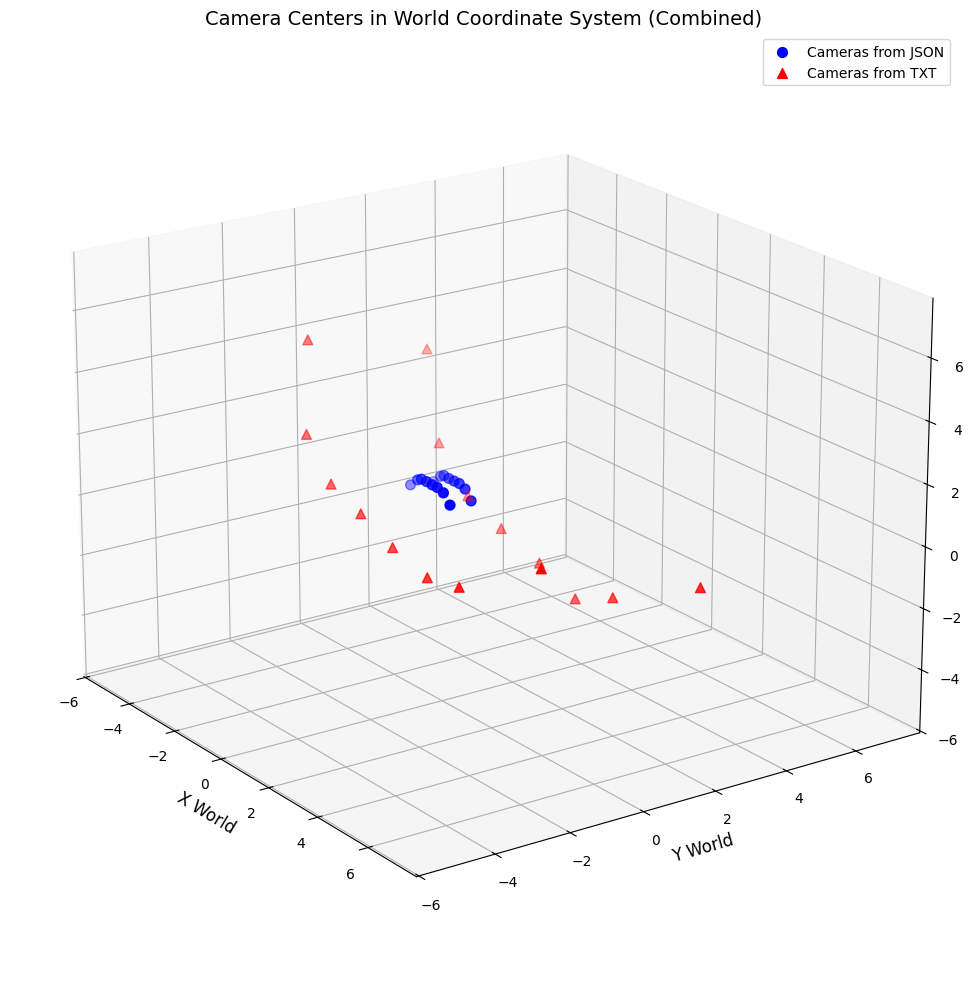

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ==============================
# 1. 读取JSON文件
# ==============================
json_path = "./camera_params.json"  # 请修改为实际路径
with open(json_path, 'r') as f:
    data = json.load(f)

# ==============================
# 2. 提取JSON文件的相机外参
# ==============================
camera_centers_json = []
camera_ids_json = []

# 遍历所有相机ID
for cam_id, extrinsic_matrix in data["world_2_cam"].items():
    # 转换为numpy数组
    extrinsic = np.array(extrinsic_matrix)

    # 验证矩阵尺寸
    if extrinsic.shape != (4, 4):
        print(f"警告：相机 {cam_id} 的外参矩阵尺寸异常")
        continue

    # 提取旋转和平移
    R = extrinsic[:3, :3]
    t = extrinsic[:3, 3]

    # 计算相机中心：C = -R^T * t
    camera_center = -R.T @ t

    camera_centers_json.append(camera_center)
    camera_ids_json.append(cam_id)

# 转换为numpy数组方便处理
camera_centers_json = np.array(camera_centers_json)


def quaternion_to_rotation_matrix(q):
    """Convert a quaternion to a rotation matrix."""
    q = q / np.linalg.norm(q)  # Normalize the quaternion

    q_w, q_x, q_y, q_z = q
    R = np.array([
        [1 - 2 * (q_y**2 + q_z**2), 2 * (q_x*q_y - q_w*q_z), 2 * (q_x*q_z + q_w*q_y)],
        [2 * (q_x*q_y + q_w*q_z), 1 - 2 * (q_x**2 + q_z**2), 2 * (q_y*q_z - q_w*q_x)],
        [2 * (q_x*q_z - q_w*q_y), 2 * (q_y*q_z + q_w*q_x), 1 - 2 * (q_x**2 + q_y**2)]
    ])
    return R

def read_camera_positions_from_txt(images_file):
    """
    Reads camera positions from the images.txt file.

    Args:
        images_file (str): Path to the images.txt file.

    Returns:
        Tuple: (camera_centers, camera_ids) - Camera centers and their IDs.
    """

    camera_centers = []
    camera_ids = []

    with open(images_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('#') or not line:  # Skip comments and empty lines
                continue

            parts = line.split()

            if len(parts) != 10:  # Check if the line has enough data
                continue

            try:
                qw, qx, qy, qz = map(float, parts[1:5])
                tx, ty, tz = map(float, parts[5:8])
                camera_id = int(parts[8])

                # Convert quaternion to rotation matrix
                q = np.array([qw, qx, qy, qz])
                R = quaternion_to_rotation_matrix(q)

                # Camera center calculation
                T = np.array([tx, ty, tz])
                C = -np.dot(R.T, T)

                camera_centers.append(C)
                camera_ids.append(camera_id)

            except ValueError as e:
                print(f"Skipping line due to parsing error: {line} - {e}")
                continue

    return np.array(camera_centers), camera_ids

# ==============================
# 3. 读取images.txt的相机外参 (假设您已经有一个函数来读取)
# ==============================
images_file = '/media/DGST_data/Test_Data/056/EMO-1-shout+laugh/1/psiftproject/sparse/1/images.txt'  # 替换为你的 images.txt 文件路径
camera_centers_txt, camera_ids_txt = read_camera_positions_from_txt(images_file)


# ==============================
# 4. 可视化
# ==============================
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 绘制 JSON 文件的相机位置（蓝色）
ax.scatter(
    camera_centers_json[:, 0],
    camera_centers_json[:, 1],
    camera_centers_json[:, 2],
    c='blue',       # 蓝色
    marker='o',     # 圆点
    s=50,
    label='Cameras from JSON'
)

# 绘制 images.txt 文件的相机位置（红色）
ax.scatter(
    camera_centers_txt[:, 0],
    camera_centers_txt[:, 1],
    camera_centers_txt[:, 2],
    c='red',        # 红色
    marker='^',     # 三角形
    s=50,
    label='Cameras from TXT'
)

# 坐标轴设置
ax.set_xlabel('X World', fontsize=12)
ax.set_ylabel('Y World', fontsize=12)
ax.set_zlabel('Z World', fontsize=12)
ax.set_title("Camera Centers in World Coordinate System (Combined)", fontsize=14)

# 添加图例
ax.legend(loc='upper right')

# 优化显示
ax.view_init(elev=20, azim=-35)  # 设置视角
ax.grid(True)
plt.tight_layout()

# 可选：显示坐标范围 (根据两个数据集中范围的并集进行设置)
min_val = min(np.min(camera_centers_json), np.min(camera_centers_txt))
max_val = max(np.max(camera_centers_json), np.max(camera_centers_txt))
padding = (max_val - min_val) * 0.1
ax.set_xlim([min_val - padding, max_val + padding])
ax.set_ylim([min_val - padding, max_val + padding])
ax.set_zlim([min_val - padding, max_val + padding])

# 显示图形
plt.show()

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import json


import matplotlib.pyplot as plt
from matplotlib import animation
import os
from mpl_toolkits.mplot3d import Axes3D  # 确保导入 Axes3D

import matplotlib.pyplot as plt
from matplotlib import animation
import os
from mpl_toolkits.mplot3d import Axes3D

def visualize_trajectories(trajectory_data, save_path="./", max_visible_length=5):
    """
    可视化3D轨迹数据，并保存为GIF动画，限制可视化轨迹长度为max_visible_length帧。

    Args:
        trajectory_data (dict): 包含轨迹数据的字典。
        output_path (str): GIF动画的保存路径。默认为 "trajectory.gif"。
        max_visible_length (int): 可视化轨迹的最大长度（帧数）。 默认为15。
    """

    # 预处理数据
    max_length = max(t["length"] for t in trajectory_data.values())
    max_end_frame = max(t["start_frame"] + t["length"] - 1 for t in trajectory_data.values())

    # 创建3D画布
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 设置坐标轴范围
    all_points = [kp for traj in trajectory_data.values() for kp in traj["keypoints"]]
    if all_points:
        ax.set_xlim(min(p[0] for p in all_points), max(p[0] for p in all_points))
        ax.set_ylim(min(p[1] for p in all_points), max(p[1] for p in all_points))
        ax.set_zlim(min(p[2] for p in all_points), max(p[2] for p in all_points))
    else:
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_zlim(-1, 1)

    # 预创建所有轨迹的线对象
    lines = {}
    for traj_id, traj in trajectory_data.items():
        color = "green" if traj["length"] == max_length else "red"
        line, = ax.plot([], [], [],
                       color=color,
                       marker='o',
                       markersize=1,
                       linewidth=1,
                       alpha=0.7)
        lines[traj_id] = line

    def update_frame(t):
        """更新每一帧的显示"""
        ax.set_title(f"Current Frame: {t}")

        for traj_id, traj in trajectory_data.items():
            start = traj["start_frame"]
            length = traj["length"]
            keypoints = traj["keypoints"]

            # 计算当前应显示的关键点数量
            if t < start:
                visible_points = 0
            else:
                visible_points = min(t - start + 1, length)

            # 限制最大可见长度
            visible_points = min(visible_points, max_visible_length)

            # 计算要显示的关键点起始索引
            start_index = max(0, (t - start + 1) - max_visible_length)  # 关键改动

            # 更新线数据
            if visible_points > 0:
                xs = [p[0] for p in keypoints[start_index:start_index + max_visible_length]] #关键改动
                ys = [p[1] for p in keypoints[start_index:start_index + max_visible_length]] #关键改动
                zs = [p[2] for p in keypoints[start_index:start_index + max_visible_length]] #关键改动
            else:
                xs, ys, zs = [], [], []

            lines[traj_id].set_data(xs, ys)
            lines[traj_id].set_3d_properties(zs)

        return list(lines.values())

    # 创建动画
    ani = animation.FuncAnimation(
        fig,
        update_frame,
        frames=range(max_end_frame + 1),
        interval=50,
        blit=True
    )

    output_path = os.path.join(save_path, "trajectory.gif")
    # 保存为GIF
    ani.save(output_path, writer='pillow', fps=20)

    plt.close(fig)

    print(f"动画已保存到: {output_path}")

with open("./all_trajectory3D.json") as f:
    data = json.load(f)

visualize_trajectories(data)

动画已保存到: ./trajectory.gif


### 画直方图

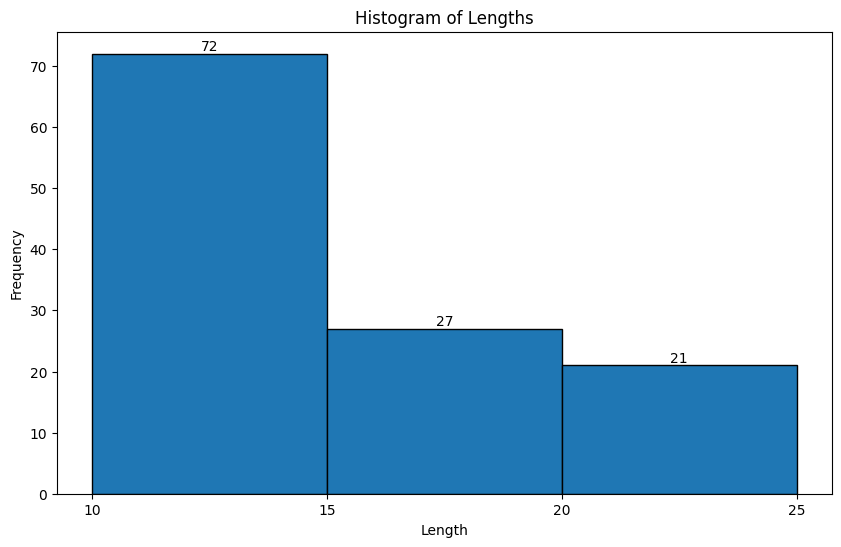

In [4]:
import json
import matplotlib.pyplot as plt
import numpy as np

# 假设你的 JSON 数据保存在名为 "trajectories.json" 的文件中
file_path = "./all_trajectory2D.json"

# 从文件中读取数据的代码：
with open(file_path, 'r') as f:
   data = json.load(f)

# 提取所有 length 值
lengths = [item["length"] for item in data.values()]

# 设置区间（从 0 开始，每隔 10）
bins = np.arange(10, max(lengths) + 6, 5)

# 统计每个区间内的 length 数量
hist, bin_edges = np.histogram(lengths, bins=bins)

# 绘制直方图
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist, width=5, align='edge', edgecolor='black')

# 标明具体值
for i in range(len(hist)):
    plt.text(bin_edges[i] + 2.5, hist[i], str(hist[i]), ha='center', va='bottom')

plt.xlabel("Length")
plt.ylabel("Frequency")
plt.title("Histogram of Lengths")
plt.xticks(bins)

plt.show()